# Cleaning the LAMOST DR8 Dataset

In [1]:
# importing required packages
from astropy.table import Table
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
import os

In [2]:
# importing tables
start = time()
os.chdir('/arc/projects/k-pop/catalogues/')
lrs = Table.read('lamost-lrs-dr8v2.fits').to_pandas() # General LRS catalogue (no labels)
mrs = Table.read('lamost-mrs-dr8v2.fits').to_pandas() # General MRS catalogue (no labels)
lrsparamp = Table.read('lamost-param/dr8_v2_LRS_stellar.fits').to_pandas() # LRS parameter catalogue (AGKM)
lrsm = Table.read('lamost-param/dr8_v2_LRS_mstellar.fits').to_pandas() # LRS M class stars (dwarfs or giants)
# lrsmec = Table.read('lamost-param/dr8_v2_LRS_mec.fits').to_pandas() # LRS Multi-Epoch Catalogue
mrsparamp = Table.read('lamost-param/dr8_v2_MRS_stellar.fits').to_pandas() # MRS parameter catalogue
# mrsmec = Table.read('lamost-param/dr8_v2_MRS_mec.fits').to_pandas() # MRS Multi-Epoch Catalogue
end = time()
print('Time Elapsed:',round(end-start,1),'s')

Time Elapsed: 475.7 s


Lets start first with the low resolution spectra,

The descriptions of the columns in the lrs are given from this webpage: [LAMOST LRS General Catalogue](http://www.lamost.org/dr8/v2.0/doc/lr-data-production-description#S3.1)

In [3]:
lrsstars = lrs[lrs['class'] == b'STAR'] # selecting only stars

Check to make sure that the AFGK catalogue is a subset of the general catalogue with cuts made such that the stellar labels are the same.

In [4]:
A = lrsparamp['obsid'].values
B = lrsstars['obsid'].values
if(set(A).issubset(set(B))):
    print("Yes, column is subset of other.")

Yes, column is subset of other.


So if this is the case, then there is no need to use the general catalogue to make cuts, because there exist no stellar labels for the stars that are a part of the general catalogue and not a part of the AFGK catalogue. \
Therefore to get the "normal" stars, i.e. no white dwarfs, variables, drawfs, or giants, we can just use the AFGK stars as there are no labels for the other ones in the general catalogue.

<!-- Selection criteria of this catalogue: S/N in g band larger than 6 in dark nights, S/N in g band larger than 15 in bright nights -->

In [5]:
# 20 snr cut from Green et al. 2020 (https://arxiv.org/pdf/2006.16258.pdf)
lrsparamp_n = lrsparamp[(lrsparamp['snru'] > 20) | (lrsparamp['snrg'] > 20) | (lrsparamp['snrr'] > 20) | (lrsparamp['snri'] > 20) | (lrsparamp['snrz'] > 20)]
# remove -9999 vals and cuts from analysis by Chen & Shu 2022 (https://arxiv.org/pdf/2202.13563.pdf)
lrsparamp_n = lrsparamp_n[(lrsparamp_n['teff_err'] <= 200) & (lrsparamp_n['logg_err'] <= 0.2) & \
                      (lrsparamp_n['feh_err'] <= 0.2) & (lrsparamp_n['teff_err'] > 0) & (lrsparamp_n['rv_err'] > 0) & \
                      (lrsparamp_n['logg_err'] > 0) & (lrsparamp_n['feh_err'] > 0) & (lrsparamp_n['alpha_m_err'] > 0)]
len(lrsparamp_n)

3798458

 There are total 32%, 60%, and 78% of stars
with the error of Teff ≤ 100 K / logg ≤ 0.1 / [Fe/H] ≤ 0.1, the error of Tef f ≤ 200 K / logg ≤ 0.2 /
[Fe/H] ≤ 0.2, and the error of Tef f ≤ 300 K / logg ≤ 0.3 / [Fe/H] ≤ 0.3 in the AFGK catalogue from Li et al.

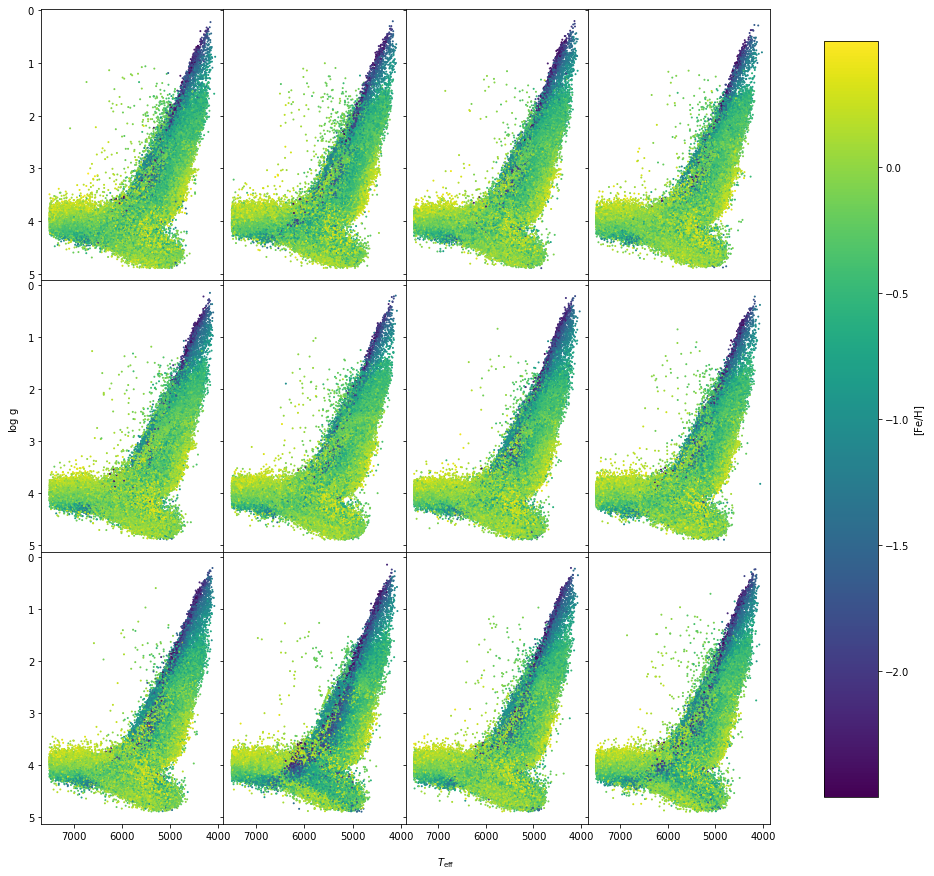

In [6]:
# breaking up the plots because they are too many points
# dfs = np.array_split(lrsparamp[lrsparamp['teff'] <= 7000],24)
dfs = np.array_split(lrsparamp_n,12)

fig = plt.figure(figsize=(15,15))
# plt.title('Selected Stars: %i' %len(df))
gs = fig.add_gridspec(3, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
axs[0,0].invert_yaxis()
axs[0,0].invert_xaxis()
axs[1,0].invert_yaxis()
axs[0,1].invert_xaxis()
axs[2,0].invert_yaxis()
axs[0,2].invert_xaxis()
# axs[3,0].invert_yaxis()
axs[0,3].invert_xaxis()
# axs[0,4].invert_xaxis()
# axs[0,5].invert_xaxis()
fig.text(0.5, 0.09, r'$T_{\rm eff}$', ha='center', va='center')
fig.text(0.1, 0.5, r'${\rm log\ g}$', ha='center', va='center', rotation='vertical')
    
for df,ax in zip(dfs,axs.flat):
    plots = ax.scatter(df['teff'].values, df['logg'].values, c=df['feh'].values, s=1, rasterized=True)
    
fig.subplots_adjust(right=0.8)
cbar = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plots,cax=cbar,label=r'${\rm [Fe/H]}$');

In [7]:
lrsparamp_ = lrsparamp[(lrsparamp['snru'] > 20) | (lrsparamp['snrg'] > 20) | (lrsparamp['snrr'] > 20) | (lrsparamp['snri'] > 20) | (lrsparamp['snrz'] > 20)]
lrsparamp_ = lrsparamp_[(lrsparamp_['teff_err'] <= 200) & (lrsparamp_['logg_err'] <= 0.2) & \
                      (lrsparamp_['feh_err'] <= 0.2) & (lrsparamp_['teff_err'] > 0) & (lrsparamp_['rv_err'] > 0) & \
                      (lrsparamp_['logg_err'] > 0) & (lrsparamp_['feh_err'] > 0)]
len(lrsparamp_)

6223450

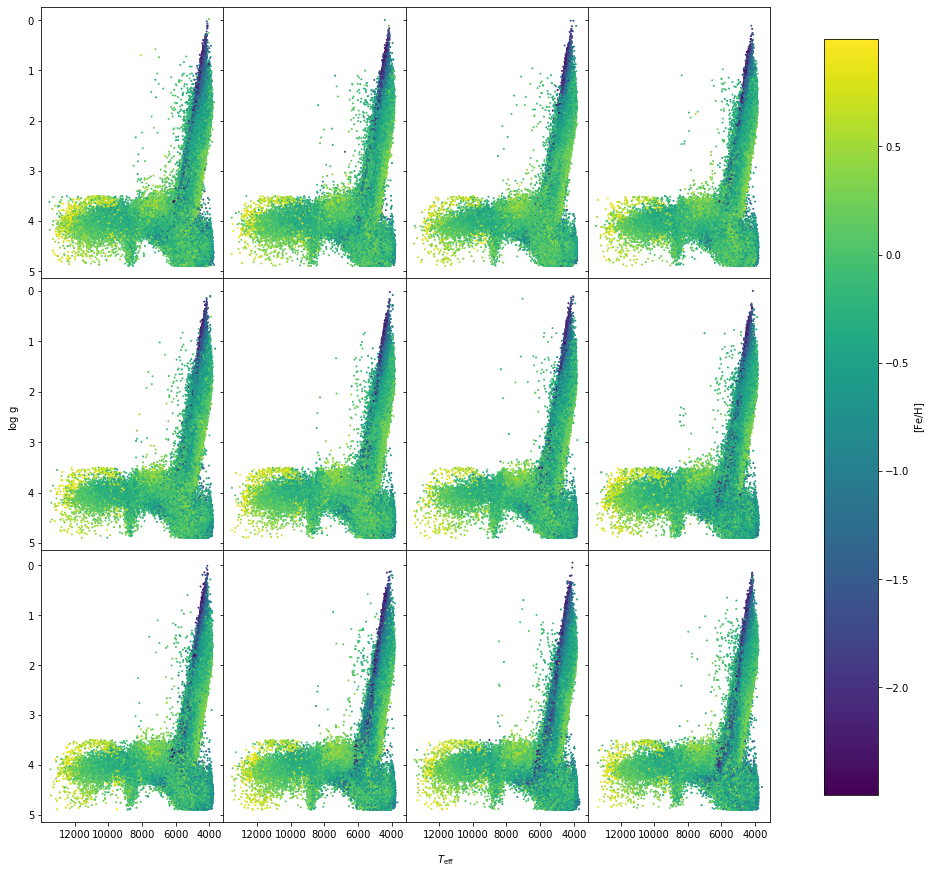

In [8]:
dfs = np.array_split(lrsparamp_,12)

fig = plt.figure(figsize=(15,15))
# plt.title('Selected Stars: %i' %len(df))
gs = fig.add_gridspec(3, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
axs[0,0].invert_yaxis()
axs[0,0].invert_xaxis()
axs[1,0].invert_yaxis()
axs[0,1].invert_xaxis()
axs[2,0].invert_yaxis()
axs[0,2].invert_xaxis()
# axs[3,0].invert_yaxis()
axs[0,3].invert_xaxis()
# axs[0,4].invert_xaxis()
# axs[0,5].invert_xaxis()
fig.text(0.5, 0.09, r'$T_{\rm eff}$', ha='center', va='center')
fig.text(0.1, 0.5, r'${\rm log\ g}$', ha='center', va='center', rotation='vertical')
    
for df,ax in zip(dfs,axs.flat):
    plots = ax.scatter(df['teff'].values, df['logg'].values, c=df['feh'].values, s=1, rasterized=True)
    
fig.subplots_adjust(right=0.8)
cbar = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plots,cax=cbar,label=r'${\rm [Fe/H]}$');

In [9]:
# Kiel diagrams look good, now lets format them correctly to match the other catalogues
lrsparamp_n['origin'] = 'LAMOST_DR8_LRS'

In [10]:
required_columns = ['gaia_source_id', 'origin', 'obsid', 'ra', 'dec', 'rv', 'rv_err', 'teff', 'teff_err', 
                    'logg', 'logg_err', 'feh', 'feh_err', 'alpha_m', 'alpha_m_err']

In [11]:
lrsparamp_n = lrsparamp_n[required_columns]

In [12]:
#Change columns names 
final_columns_names = ['dr3_source_id', 'origin', 'origin_id', 'ra', 'dec', 'rv', 'e_rv', 'teff', 'e_teff', 
                    'logg', 'e_logg', 'feh', 'e_feh', 'alpha_fe', 'e_alpha_fe']

In [13]:
lrsparamp_n.columns = final_columns_names

In [14]:
lrsparamp_n.dropna(inplace=True)

In [15]:
# lrsparamp_n.to_parquet('calsurvey/lamost_dr8_lrs_filtered_intermediary.parquet', index=False)

Now check the Giants and dwarfs catalogue:

I'm using these cuts from Shen et al. 2022 (https://arxiv.org/pdf/2206.03632.pdf)

In [16]:
# lrsm.columns

In [17]:
A = lrsm['obsid'].values
B = lrsstars['obsid'].values
if(set(A).issubset(set(B))):
    print("Yes, column is subset of other.")

Yes, column is subset of other.


In [18]:
lrsm_n = lrsm[(lrsm['teff'] > 0) & (lrsm['teff_err'] <= 200) & (lrsm['logg_err'] <= 0.2) & \
              (lrsm['m_h_err'] <= 0.2) & (lrsm['teff_err'] > 0) & \
              (lrsm['logg_err'] > 0) & (lrsm['m_h_err'] > 0)]

In [19]:
lrsm_n = lrsm[(lrsm['ewha_err'] >= 0) & (lrsm['tio5_err'] >= 0) & (lrsm['zeta_err'] >= 0) & \
              (lrsm['tio4_err'] >= 0) & (lrsm['tio2_err'] >= 0) & (lrsm['snri'] >= 5) & \
              (lrsm['tio3_err'] >= 0) & (lrsm['tio1_err'] >= 0) & \
              (lrsm['cah1_err'] >= 0) & (lrsm['cah2_err'] >= 0) & \
              (lrsm['cah3_err'] >= 0) & (lrsm['caoh_err'] >= 0) & \
              (lrsm['teff'] > 0) & (lrsm['teff_err'] <= 200) & (lrsm['logg_err'] <= 0.2) & \
              (lrsm['m_h_err'] <= 0.2) & (lrsm['teff_err'] > 0) & \
              (lrsm['logg_err'] > 0) & (lrsm['m_h_err'] > 0)]

(6.0, 0.0)

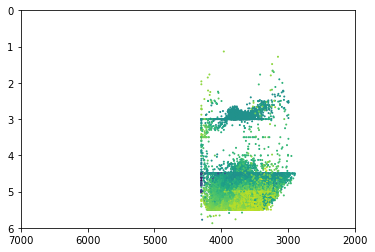

In [20]:
plt.scatter(lrsm_n['teff'].values, lrsm_n['logg'].values, c=lrsm_n['m_h'].values, s=1, rasterized=True)
# plt.gca().invert_xaxis()
plt.xlim(7000,2000)
plt.ylim(6,0)
# plt.gca().invert_yaxis()

In [21]:
lrsm[lrsm['teff'] > 0]['teff'].value_counts()

3700.000000    9964
3800.000000    6042
3600.000000    5159
3500.000000    3194
3400.000000    1527
               ... 
3286.879883       1
2965.719971       1
3058.489990       1
3198.550049       1
4150.709961       1
Name: teff, Length: 92742, dtype: int64

In [22]:
lrsm['logg'][lrsm['teff'] > 0].value_counts()

5.000    39139
4.500    26489
3.000     7928
5.500     4476
5.001     1392
         ...  
1.238        1
3.411        1
0.920        1
1.297        1
0.651        1
Name: logg, Length: 4953, dtype: int64

As seen from the cuts made and from the value counts, whatever pipeline they are using to derive these spec labels prefers nice whole numbers and severely messes with the resulting Kiel diagram. Will not be including this catalogue for the time being.

Now we follow the same system as before with the lrs for the mrs from LAMOST

[LAMOST MRS General Catalogue](http://www.lamost.org/dr8/v2.0/doc/mr-data-production-description#s3.1)

In [23]:
# Following the same cuts as above from Green et al. 2020
mrs_n = mrsparamp[mrsparamp['snr'] > 20]
# following the above of Chen & Shu 2022
mrs_n = mrs_n[(mrs_n['teff_lasp_err'] <= 300) & (mrs_n['logg_lasp_err'] <= 0.3) & \
              (mrs_n['feh_lasp_err'] <= 0.3) & (mrs_n['teff_lasp_err'] > 0) & (mrs_n['rv_lasp1_err'] > 0) & \
              (mrs_n['logg_lasp_err'] > 0) & (mrs_n['feh_lasp_err'] > 0) & (mrs_n['alpha_m_lasp_err'] > 0)]
# rv_lasp1 is the zero-point corrected rv, whereas rv_lasp0 is not zero-point corrected.

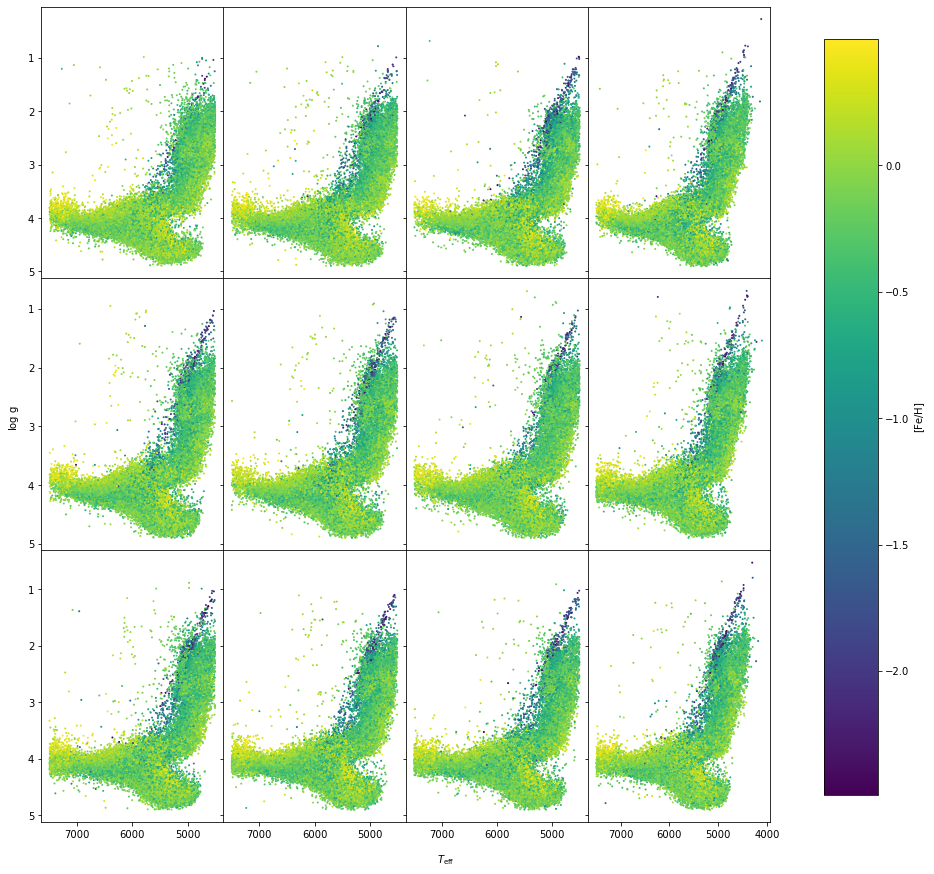

In [24]:
# breaking up the plots because they are too many points
# dfs = np.array_split(lrsparamp[lrsparamp['teff'] <= 7000],24)
dfs = np.array_split(mrs_n,12)

fig = plt.figure(figsize=(15,15))
# plt.title('Selected Stars: %i' %len(df))
gs = fig.add_gridspec(3, 4, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
axs[0,0].invert_yaxis()
axs[0,0].invert_xaxis()
axs[1,0].invert_yaxis()
axs[0,1].invert_xaxis()
axs[2,0].invert_yaxis()
axs[0,2].invert_xaxis()
# axs[3,0].invert_yaxis()
axs[0,3].invert_xaxis()
# axs[0,4].invert_xaxis()
# axs[0,5].invert_xaxis()
fig.text(0.5, 0.09, r'$T_{\rm eff}$', ha='center', va='center')
fig.text(0.1, 0.5, r'${\rm log\ g}$', ha='center', va='center', rotation='vertical')
    
for df,ax in zip(dfs,axs.flat):
    plots = ax.scatter(df['teff_lasp'].values, df['logg_lasp'].values, c=df['feh_lasp'].values, s=1, rasterized=True)
    
fig.subplots_adjust(right=0.8)
cbar = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(plots,cax=cbar,label=r'${\rm [Fe/H]}$');

In [25]:
# Kiel diagrams look good, time to combine and save the table.
mrs_n['origin'] = 'LAMOST_DR8_MRS'

In [26]:
required_columns = ['gaia_source_id', 'origin', 'obsid', 'ra', 'dec', 'rv_lasp1', 'rv_lasp1_err', 'teff_lasp', 'teff_lasp_err', 
                    'logg_lasp', 'logg_lasp_err', 'feh_lasp', 'feh_lasp_err', 'alpha_m_lasp', 'alpha_m_lasp_err']

In [27]:
mrs_n = mrs_n[required_columns]

In [28]:
#Change columns names 
final_columns_names = ['dr3_source_id', 'origin', 'origin_id', 'ra', 'dec', 'rv', 'e_rv', 'teff', 'e_teff', 
                    'logg', 'e_logg', 'feh', 'e_feh', 'alpha_fe', 'e_alpha_fe']

In [29]:
mrs_n.columns = final_columns_names

In [30]:
mrs_n.dropna(inplace=True)

In [31]:
# combining the tables of MRS and LRS
lrsmrs = pd.concat([lrsparamp_n, mrs_n])

In [32]:
# turning the dr3 source ids to ints instead of bytes
lrsmrs = lrsmrs.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)

In [33]:
# turning the dr3 source ids to strings instead of ints
lrsmrs['dr3_source_id'] = lrsmrs['dr3_source_id'].astype('string')

In [34]:
# saving the file
lrsmrs.to_csv('calsurvey/lamost_dr8_lrs_mrs_filtered.csv', index=False, header=True)
# lrsmrs.to_parquet('calsurvey/lamost_dr8_lrs_mrs_filtered.parquet', index=False)

In [35]:
input_survey = 'calsurvey/lamost_dr8_lrs_mrs_filtered.csv'
output_binaries_survey = 'calsurvey/lamost_dr8_binaries.csv'
output_variability_survey = 'calsurvey/lamost_dr8_variables.csv'
output_survey = 'calsurvey/lamost_dr8_lrs_mrs_filtered.parquet'

match_radius = 1.

In [36]:
cds_binaries = 'I/357/tbosb1'
cds_variables = 'I/358/vclassre'

In [37]:
#Match with binaries
stilts_command = "stilts cdsskymatch \
                  cdstable=%s  find=best \
                  in=%s ifmt=csv \
                  ra=ra dec=dec radius=%d \
                  out=%s ofmt=csv" %(cds_binaries, input_survey, match_radius, output_binaries_survey)

In [38]:
%%time
os.system(stilts_command)

CPU times: user 6.45 ms, sys: 6.57 ms, total: 13 ms
Wall time: 2min 32s


0

In [39]:
#Match with variables
stilts_command = 'stilts cdsskymatch \
                  cdstable=%s  find=best \
                  in=%s ifmt=csv \
                  ra=ra dec=dec radius=%d \
                  out=%s ofmt=csv' %(cds_variables, input_survey, match_radius, output_variability_survey)

In [40]:
%%time
os.system(stilts_command)

CPU times: user 39.1 ms, sys: 24.4 ms, total: 63.4 ms
Wall time: 14min 46s


0

In [41]:
#Read binaries and variables to merge and then perform inverse selection on filtered table
binaries = pd.read_csv(output_binaries_survey)
variables = pd.read_csv(output_variability_survey)

In [42]:
#Drop all the columns except dr3_source_id
binaries = binaries.pop('dr3_source_id')
variables = variables.pop('dr3_source_id')

In [43]:
bin_var = pd.concat([binaries, variables], ignore_index=True)

In [44]:
bin_var.drop_duplicates(keep='first', inplace=True)

In [45]:
f_in1d = np.in1d(lrsmrs.dr3_source_id.values, bin_var.values, invert=True)

In [46]:
lrsmrs_filtered = lrsmrs[f_in1d]

In [47]:
lrsmrs_filtered.to_parquet(output_survey, index=False)

In [48]:
#Remove all the intermediate step catalogues before finish
os.system('rm %s' %output_binaries_survey)
os.system('rm %s' %output_variability_survey)
os.system('rm %s' %input_survey)

0

In [49]:
!ls -lhtr calsurvey

total 480M
-rw-r--r--. 1 sfabbro    sfabbro     140 Dec  6 14:19 columns.txt
-rw-r--r--. 1 sfabbro    sfabbro    774K Dec  6 14:48 galah.ipynb
-rwxrwxrwx. 1 fgran      fgran      270K Dec  6 15:46 APOGEE_selection_sos.ipynb
-rw-rwxr--+ 1 sfabbro    sfabbro     30M Dec  6 15:57 galah_dr3_filtered.parquet
-rwxrwxrwx. 1 fgran      fgran       14K Dec 15 20:23 Remove_binaries_variables.ipynb
-rw-r--r--+ 1 aydanmckay aydanmckay 1.6M Jan  6 23:13 lamostdr8.ipynb
-rw-r--r--. 1 fgran      fgran       38M Jan 10 14:04 apogee_dr17_filtered.parquet
-rw-rw-r--+ 1 fgran      fgran       75M Jan 10 14:04 apogee_dr17_filtered.csv
-rw-rw-r--+ 1 fgran      fgran       28M Jan 10 14:44 galah_filtered.parquet
-rw-rw-r--+ 1 fgran      fgran       64M Jan 10 14:44 galah_filtered.csv
-rw-rw-r--+ 1 aydanmckay aydanmckay 245M Jan 16 22:54 lamost_dr8_lrs_mrs_filtered.parquet


In [50]:
lrsmrs

,dr3_source_id,origin,origin_id,ra,dec,rv,e_rv,teff,e_teff,logg,e_logg,feh,e_feh,alpha_fe,e_alpha_fe
0,1593192490383030656,LAMOST_DR8_LRS,795504014,223.972988,50.313702,-52.849998,4.25,6043.520020,27.410000,4.203,0.037,-1.008,0.021,0.186166,0.015606
1,1592435682785905664,LAMOST_DR8_LRS,795504017,223.907226,50.246069,-36.540001,4.17,5108.709961,29.150000,3.485,0.040,-0.600,0.024,0.512312,0.035807
2,1592443619885478272,LAMOST_DR8_LRS,795504018,224.111400,50.351806,-254.039993,4.09,6220.870117,22.770000,4.157,0.029,-1.148,0.015,0.130977,0.021742
3,1593291721307104512,LAMOST_DR8_LRS,795504026,224.248337,50.644345,-14.160000,5.04,5857.229980,28.830000,4.122,0.037,-0.006,0.020,0.055852,0.038135
7,1592536661760302336,LAMOST_DR8_LRS,795504037,224.498867,50.528953,-41.049999,6.73,5464.970215,49.470001,4.385,0.071,0.256,0.043,0.200824,0.055528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209086,1893651463060577280,LAMOST_DR8_MRS,762410194,331.873502,29.139385,-17.930000,2.15,4479.399902,86.720001,2.593,0.077,-0.438,0.051,0.355000,0.085950
1209093,1893788833294316160,LAMOST_DR8_MRS,762401023,334.560644,27.719087,-38.639999,1.34,4393.169922,47.689999,2.642,0.057,-0.424,0.034,0.252000,0.084314
1209098,1894137855219861760,LAMOST_DR8_MRS,762402054,333.346343,28.592842,-45.740002,1.21,4392.359863,31.700001,2.238,0.035,-0.461,0.022,0.245000,0.066905
1209132,1898305798860560256,LAMOST_DR8_MRS,762414167,332.261712,30.496486,-46.820000,2.06,4420.609863,83.940002,2.013,0.071,-0.485,0.046,0.320000,0.094649
